In [9]:
# imports

import pandas as pd
from layers import Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Charger les données
splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'validation': 'data/validation-00000-of-00001.parquet',
    'test': 'data/test-00000-of-00001.parquet'
}

df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])

# Afficher les premières lignes pour vérifier
print(df_train.head())

   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2
2   2                 and that is why, the lonesome day,      0
3   3  when i peruse the conquered fame of heroes, an...      3
4   4            of inward strife for truth and liberty.      3


In [12]:

X_train, Y_train, X_validation, Y_validation, X_test, Y_test = df_train['verse_text'].values, df_train['label'].values, df_val['verse_text'].values, df_val['label'].values, df_test['verse_text'].values, df_test['label'].values

sequence_length = 900
vocabulary_size = 10000  # choose 10k most-used words for truncated vocabulary

# Tokenize the text
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_validation)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences=X_train, maxlen=sequence_length)
X_validation = pad_sequences(sequences=X_validation, maxlen=sequence_length)
X_test = pad_sequences(sequences=X_test, maxlen=sequence_length)

print("Distribution des classes dans Y_train :", np.bincount(Y_train))
print("Distribution des classes dans Y_validation :", np.bincount(Y_validation))
print("Distribution des classes dans Y_test :", np.bincount(Y_test))

print("X_train shape :", X_train.shape)
print("Y_train shape :", Y_train.shape)
print("X_validation shape :", X_validation.shape)
print("Y_validation shape :", Y_validation.shape)
print("X_test shape :", X_test.shape)
print("Y_test shape :", Y_test.shape)

Distribution des classes dans Y_train : [155 133 555  49]
Distribution des classes dans Y_validation : [19 17 69]
Distribution des classes dans Y_test : [19 16 69]
X_train shape : (892, 900)
Y_train shape : (892,)
X_validation shape : (105, 900)
Y_validation shape : (105,)
X_test shape : (104, 900)
Y_test shape : (104,)


In [14]:
# Paramètres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 128  # Dimension des embeddings
lstm_units = 64  # Unités LSTM
max_length = 900  # Longueur maximale des séquences

# Entrée
input_layer = Input(shape=(max_length,))

# Couche d'embedding
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

# Couche LSTM
lstm_layer = LSTM(units=lstm_units, return_sequences=True)(embedding_layer)

# Extraire uniquement le dernier timestep de la LSTM
last_timestep = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(lstm_layer)

# Attention globale
context_vector = Attention(context='many-to-one', alignment_type='global', score_function='dot')([lstm_layer, lstm_layer[:, -1, :]])

# Pooling global pour réduire la dimension temporelle
pooling_layer = GlobalAveragePooling1D()(context_vector[0])

# Couche de sortie
output_layer = Dense(units=4, activation='softmax')(pooling_layer)  # 4 classes (0, 1, 2, 3)

# Modèle
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 900)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 900, 128)  │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 900, 64)   │     49,408 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 64)        │          0 │ lstm_2[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ [(None, 900, 64), │          0 │ lstm_2[0][0],     │
│ (Attention)         │ (None, 900, 1)]   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention_2[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        260 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,329,668 (5.07 MB)

 Trainable params: 1,329,668 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Entraînement
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_validation, Y_validation)
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 762ms/step - accuracy: 0.5222 - loss: 1.1568 - val_accuracy: 0.6571 - val_loss: 0.9446
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 644ms/step - accuracy: 0.5979 - loss: 1.0828 - val_accuracy: 0.6571 - val_loss: 0.9497
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step - accuracy: 0.6318 - loss: 1.0352 - val_accuracy: 0.6571 - val_loss: 0.9452
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.6200 - loss: 1.0524 - val_accuracy: 0.6571 - val_loss: 0.9351
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 782ms/step - accuracy: 0.6283 - loss: 1.0439 - val_accuracy: 0.6571 - val_loss: 0.9505
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 563ms/step - accuracy: 0.6039 - loss: 1.0692 - val_accuracy: 0.6571 - val_loss: 0.9332
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 590ms/step - accuracy: 0.6116 - loss: 1.0901 - val_accuracy: 0.6571 - val_loss: 0.9350
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 660ms/step - accuracy: 0.6235 - loss: 1.0382 - val_accu

In [17]:
#  Évaluation
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.6425 - loss: 0.9562
Test Loss: 0.9279966354370117
Test Accuracy: 0.6634615659713745


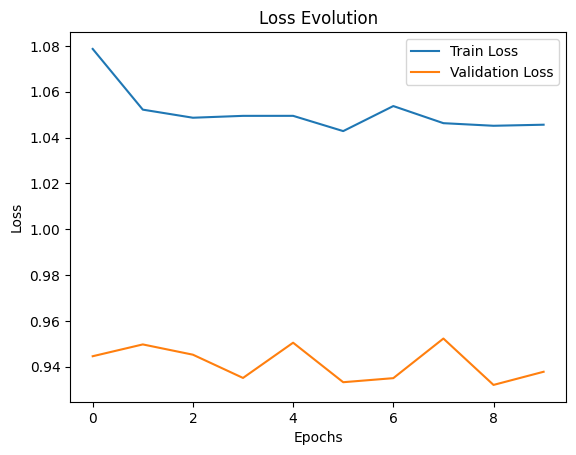

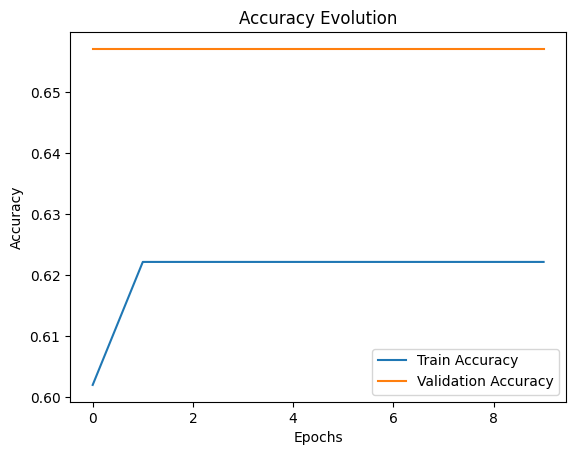

In [19]:
# Tracer la perte d'entraînement et de validation
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer la précision d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()